# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wxi1q_qv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wxi1q_qv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=687ae4f1aecd15d7678a5f96831a1961c3b4e1161e6585bab9c29827447a505c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsrwfaeo/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2026-01-09 16:25:39--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [6]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

sam_vit_h_4b8939.pth: 2.39GB [00:22, 113MB/s]                                   


In [7]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [8]:
import os
from torchvision.datasets.utils import download_url

In [9]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Mounted at /content/gdrive/
Google drive not mounted


In [ ]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

100%|██████████| 80.9M/80.9M [00:08<00:00, 9.65MB/s]


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [12]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

(112, 256, 256, 1) float32
(112, 256, 256, 1) uint8
(112, 256, 256, 3) uint8
(112, 256, 256) uint8


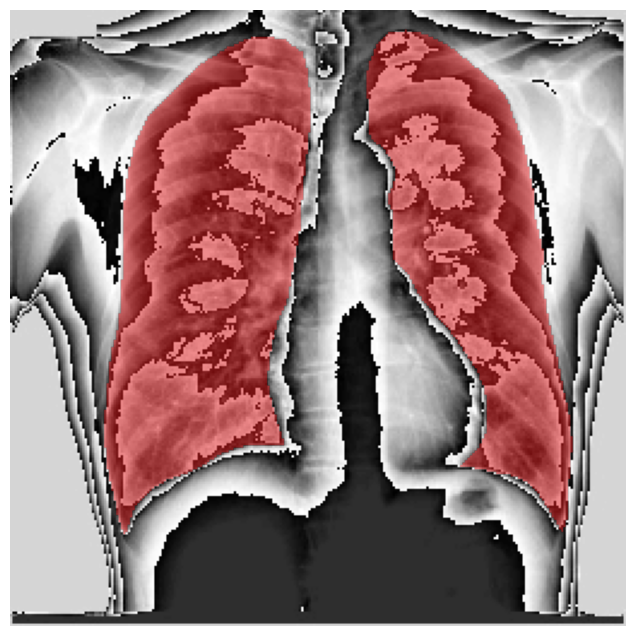

In [13]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

#  transform from float [0,1] to uint8 [0,255]
x_train = (x_train*255).astype(np.uint8)
x_val = (x_val*255).astype(np.uint8)
x_test= (x_test*255).astype(np.uint8)

# (N, H, W, 1) → (N, H, W, 3)
# triplicatiing channels
x_train = np.repeat(x_train, 3, axis=-1)
x_val = np.repeat(x_val, 3 , axis= -1)
x_test = np.repeat(x_test, 3 , axis=-1)

# squezing to be in (N, H, W)
y_train = y_train.squeeze(-1)
y_val  = y_val.squeeze(-1)
y_test  = y_test.squeeze(-1)

print(x_train.shape, x_train.dtype)
print(y_train.shape,y_train.dtype)

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

## approach 1 - single point + background on spinal colomn

In [ ]:

example_img, example_mask = x_train[0], y_train[0]

#  foreground and background
input_points = np.array([
    [100, 128],  #foreground (lung)
    [128, 128]   #we add background (spinal column in the middle)
])
input_label = np.array([1, 0])  # 1= foreground, 0=background

example_img.shape

(256, 256, 3)

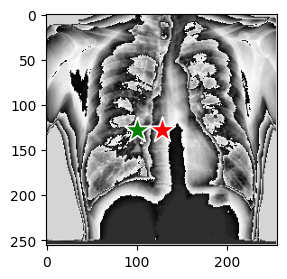

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

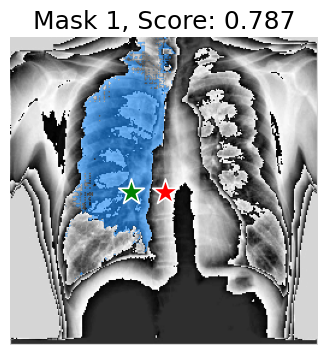

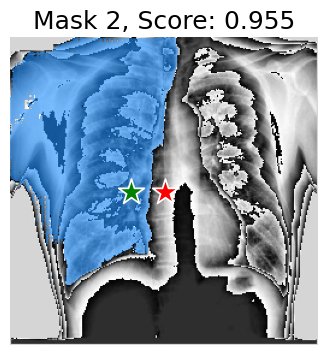

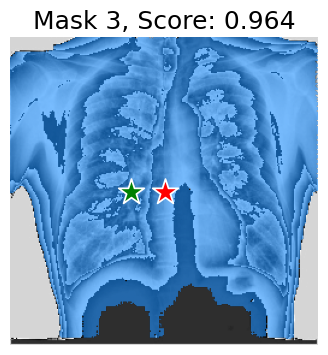

In [ ]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## approach 2 - boxes

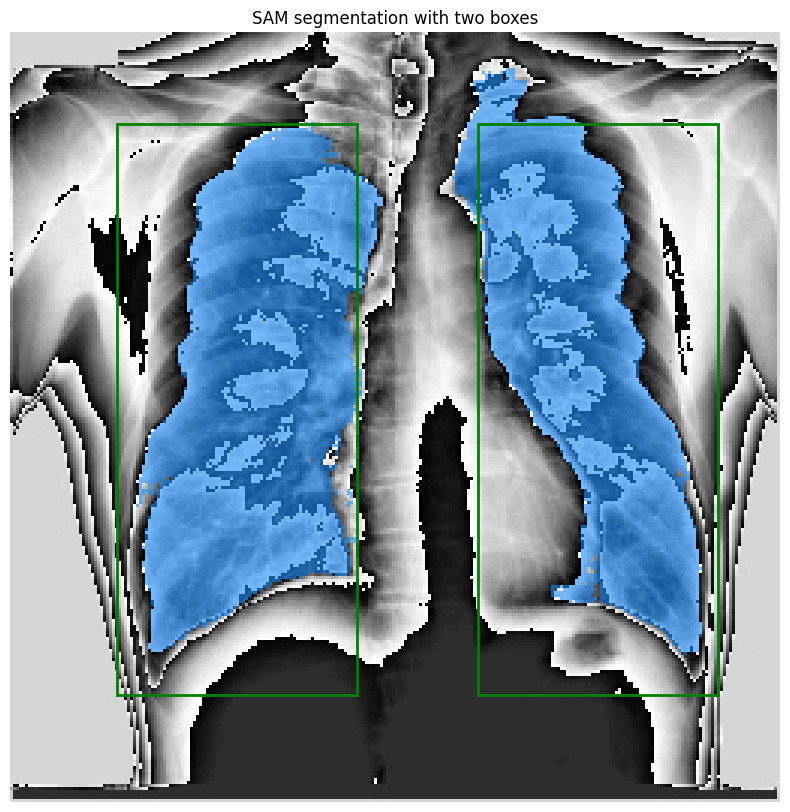

In [ ]:
# Box on 2 lungs (xyxy)
input_boxes = torch.tensor([
    [35, 30, 115, 220],  # left lung
    [155, 30, 235, 220],  # right lung
], dtype=torch.float32, device=predictor.device)

# transform boxes to comply
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])

# predict masks with predict_torch
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False
)

# masks.shape = (num_boxes, 1, H, W)
# remove channel dim
masks = masks[:, 0, :, :]

# visual in unique picture
plt.figure(figsize=(10, 10))
plt.imshow(example_img.squeeze(), cmap='gray')

# show  masks
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca())

# show boxes
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())

plt.axis('off')
plt.title("SAM segmentation with two boxes")
plt.show()


## approach 3 - 2 points foreground on lungs + 1 background point

In [ ]:

# foreground + background
input_points = np.array([
    [75, 100],    # left lung
    [175, 100],   # right lung
    [128, 128]    # background as in 1 - spinal column
])
input_labels = np.array([1, 1, 0])  # 1=foreground, 0= background

# initial predict with 2 foreground
masks_init, scores_init, logits_init = predictor.predict(
    point_coords=input_points[:2, :],
    point_labels=input_labels[:2],
    multimask_output=True
)

mask_input = logits_init[np.argmax(scores_init), :, :]

# final pred with foreground + background
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input=mask_input[None, :, :],
    multimask_output=False
)

# pick best one
mask_pred = masks[0]


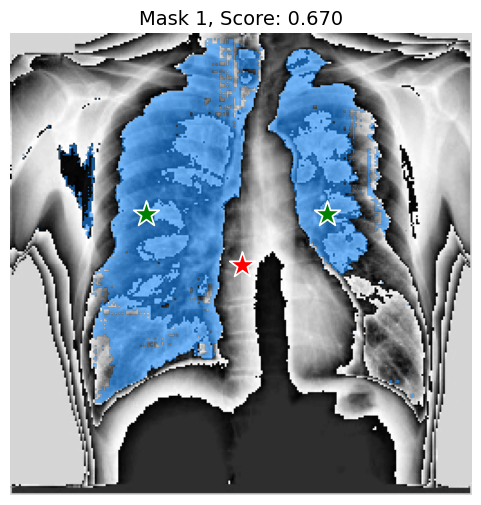

In [ ]:
# Visual mask + score
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(6,6))
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=14)
    plt.axis('off')
    plt.show()


# Evaluation loop

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 45.7 MB/s eta 0:00:00


## approach 1: 1  foreground + 1 background

In [ ]:

import torchmetrics

device = predictor.device
f1 = torchmetrics.F1Score(task="binary").to(device)
f1_scores = []

# foreground+background
input_points = np.array([
    [100, 128],
    [128, 128]
])
input_labels = np.array([1, 0])

for img, mask_gt in zip(x_val, y_val):

    predictor.set_image(img)

    masks_init, scores_init, logits_init = predictor.predict(
        point_coords=input_points[:1, :],  # foreground
        point_labels=input_labels[:1],
        multimask_output=True
    )

    mask_input = logits_init[np.argmax(scores_init), :, :]

    masks, scores, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        mask_input=mask_input[None, :, :],
        multimask_output=False
    )

    mask_pred = masks[0]

    # Convert to tensor
    mask_pred_tensor = torch.tensor(mask_pred, dtype=torch.int, device=device)
    mask_gt_tensor   = torch.tensor(mask_gt, dtype=torch.int, device=device)


    # evaluate F1
    score = f1(mask_pred_tensor, mask_gt_tensor)
    f1_scores.append(score.item())

# final statistics
f1_scores = np.array(f1_scores)
mean_f1 = np.mean(f1_scores)
std_f1  = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")


Mean F1 score: 0.5443
Standard deviation: 0.1461


## approach 2 - boxes

In [ ]:

import torchmetrics

device = predictor.device
f1 = torchmetrics.F1Score(task="binary").to(device)
f1_scores = []

# Boxes (xyxy)
boxes_template = torch.tensor([
    [35, 30, 115, 220],
    [155, 30, 235, 220],
], dtype=torch.float32)

for img, mask_gt in zip(x_val, y_val):

    predictor.set_image(img)
    H, W = img.shape[:2]

    input_boxes = boxes_template.clone()
    input_boxes[:, [0,2]] = torch.clamp(input_boxes[:, [0,2]], 0, W)
    input_boxes[:, [1,3]] = torch.clamp(input_boxes[:, [1,3]], 0, H)
    input_boxes = input_boxes.to(device)

    transformed_boxes = predictor.transform.apply_boxes_torch(
        input_boxes, img.shape[:2]
    )

    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False
    )

    masks = masks[:, 0, :, :]  # (2,H, W)

    # combination of the 2 masks
    mask_union = torch.any(masks.bool(), dim=0)

    mask_pred_tensor = mask_union.int().to(device)
    mask_gt_tensor = torch.tensor(mask_gt, dtype=torch.int, device=device)

    score = f1(mask_pred_tensor, mask_gt_tensor)
    f1_scores.append(score.item())


#final stats
f1_scores = np.array(f1_scores)
mean_f1 = np.mean(f1_scores)
std_f1  = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")


Mean F1 score: 0.8567
Standard deviation: 0.0339


## approach 3 - 2 points foreground on lungs + 1 background point

In [ ]:

import torchmetrics

device = predictor.device
f1 = torchmetrics.F1Score(task="binary").to(device)
f1_scores = []

input_points = np.array([
    [75, 100],
    [175, 100],
    [128, 128]
])
input_labels = np.array([1, 1, 0])

for img, mask_gt in zip(x_val, y_val):

    predictor.set_image(img)

    masks_init, scores_init, logits_init = predictor.predict(
        point_coords=input_points[:2, :],
        point_labels=input_labels[:2],
        multimask_output=True
    )

    mask_input = logits_init[np.argmax(scores_init), :, :]

    masks, scores, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        mask_input=mask_input[None, :, :],
        multimask_output=False
    )

    mask_pred = masks[0]

    mask_pred_tensor = torch.tensor(mask_pred, dtype=torch.int, device=device)
    mask_gt_tensor   = torch.tensor(mask_gt, dtype=torch.int, device=device)

    score = f1(mask_pred_tensor, mask_gt_tensor)
    f1_scores.append(score.item())

f1_scores = np.array(f1_scores)
mean_f1 = np.mean(f1_scores)
std_f1  = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")



Mean F1 score: 0.8169
Standard deviation: 0.0690


## qualitative analysis on approach 2

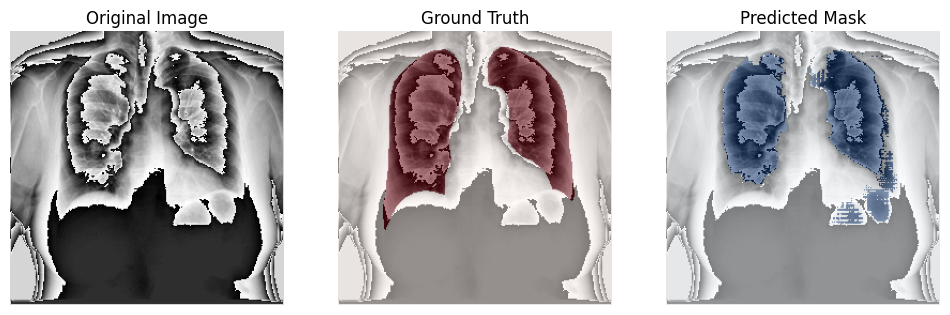

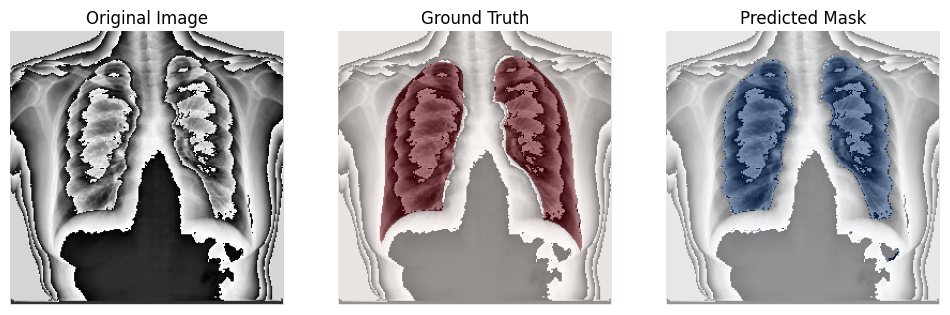

In [ ]:
# pick two images
indices = [0, 1]  # first two images

for idx in indices:
    img = x_val[idx]
    mask_gt = y_val[idx]

    #predict
    predictor.set_image(img)
    transformed_boxes = predictor.transform.apply_boxes_torch(
        boxes_template.to(device), img.shape[:2]
    )
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False
    )
    mask_pred = torch.any(masks[:, 0], dim=0).cpu().numpy()

    # plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask_gt, alpha=0.5, cmap='Reds')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask_pred, alpha=0.5, cmap='Blues')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()
